# TensorNetworks in Neural Networks.

Training the MNIST dataset using tensornetwork package from google.
#### Reference: https://github.com/google/TensorNetwork

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_v2_behavior()
import tensornetwork as tn
tn.set_default_backend("tensorflow")

# Load MNIST dataset from Keras

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data("/home/xiaochen/Fanjie/scripts/TensorNetwork/data/mnist.npz")

In [16]:
from keras.utils import to_categorical

x_train = x_train.reshape((60000, 28, 28, 1))
y_train = to_categorical(y_train, 10)
x_test = x_test.reshape((10000, 28, 28, 1))
y_test = to_categorical(y_test, 10)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(y_train)

(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


# TensorNetwork layer definition

Here, we define the TensorNetwork layer we wish to use to replace the fully connected layer. Here, we simply use a 2 node Matrix Product Operator network to replace the normal dense weight matrix.

In [17]:
def one_edge_at_a_time(a, b):
  node1 = tn.Node(a)
  node2 = tn.Node(b)
  edge1 = node1[0] ^ node2[0]
  edge2 = node1[1] ^ node2[1]
  tn.contract(edge1)
  result = tn.contract(edge2)
  return result.tensor

def use_contract_between(a, b):
  node1 = tn.Node(a)
  node2 = tn.Node(b)
  node1[0] ^ node2[0]
  node1[1] ^ node2[1]
  # This is the same as 
  # tn.contract_between(node1, node2)
  result = node1 @ node2
  return result.tensor

a = np.ones((1000, 1000))
b = np.ones((1000, 1000))

print(one_edge_at_a_time(a, b))
print(use_contract_between(a, b))

tf.Tensor(1000000.0, shape=(), dtype=float64)
tf.Tensor(1000000.0, shape=(), dtype=float64)


In [18]:
a1 = [one_edge_at_a_time(a, b) for i in range(10)]
tf.stack(a1)

<tf.Tensor: id=545, shape=(10,), dtype=float64, numpy=
array([1000000., 1000000., 1000000., 1000000., 1000000., 1000000.,
       1000000., 1000000., 1000000., 1000000.])>

# Modules for ConvAC
Tensor Network version of CNN.

In [45]:
class TNConvLayer(tf.keras.layers.Layer):
    
    def __init__(self, fov, inputShape,name):
        super(TNConvLayer, self).__init__()
        # Create the variables for the layer.
        self.variable = tf.Variable(tf.random.normal(shape=(3, 3), stddev=1.0/9), 
                                    name="conv_kernel_"+name, trainable=True)
        self.fov = fov
        self.inputShape = inputShape
        self.outputShape = (self.inputShape[0]-fov+1,  self.inputShape[1]-fov+1)
        self.bias = tf.Variable(tf.zeros(shape=self.outputShape), name="bias"+name, trainable=True)
       
    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, conv_var, bias_var):
            # Reshape to a matrix instead of a vector.
            #L, W = input_vec.shape[:2]
            input_vec = tf.reshape(input_vec, self.inputShape)
            result_list = []
            for i in range(0,  self.outputShape[0]):
                for j in range(0, self.outputShape[1]):
                    d = tn.Node(input_vec[i:i+3, j:j+3])
                    v = tn.Node(conv_var)
                    d[0] ^ v[0]
                    d[1] ^ v[1]
                    result = v @ d
                    result_list.append(result.tensor)
            final_result = tf.stack(result_list)
            final_result = tf.reshape(final_result, (self.outputShape[0], self.outputShape[1], 1))
            # Now we create the network.
            # Finally, add bias.
            return result

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.variable, self.bias), inputs)
        return tf.nn.relu(self.bias + tf.reshape(result, (-1, self.outputShape[0], self.outputShape[1], 1)))

In [29]:
class TNLayer(tf.keras.layers.Layer):
    
    def __init__(self, dim):
        super(TNLayer, self).__init__()
        # Create the variables for the layer.
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(dim, dim, 2), stddev=1.0/dim), name="b", trainable=True)
        self.bias = tf.Variable(tf.zeros(shape=(dim, dim)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, a_var, b_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (self.dim, self.dim))

            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            x_node = tn.Node(input_vec)
            a[1] ^ x_node[0]
            b[1] ^ x_node[1]
            a[2] ^ b[2]

            # The TN should now look like this
            #   |     |
            #   a --- b
            #    \   /
            #      x

            # Now we begin the contraction.
            c = a @ x_node
            result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, self.dim**2)))

In [30]:
class TriNodeTNLayer(tf.keras.layers.Layer):
    
    def __init__(self, dim, n_nodes):
        super(TriNodeTNLayer, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        self.dim = dim
        self.a_var = tf.Variable(tf.random.normal(shape=(11, 11, 2), stddev=1.0/dim), name="a", trainable=True)
        self.b_var = tf.Variable(tf.random.normal(shape=(11, 11, 2, 2), stddev=1.0/dim), name="b", trainable=True)
        self.c_var = tf.Variable(tf.random.normal(shape=(16, 16, 2), stddev=1.0/dim), name="b", trainable=True)
        
        self.bias = tf.Variable(tf.zeros(shape=(11, 11, 16)), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, a_var, b_var, c_var, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, (11, 11, 16))

            # Now we create the network.
            a = tn.Node(a_var)
            b = tn.Node(b_var)
            c = tn.Node(c_var)
            x_node = tn.Node(input_vec)
            a[1] ^ x_node[0]
            b[1] ^ x_node[1]
            c[1] ^ x_node[2]
            a[2] ^ b[2]
            b[3] ^ c[2]
            

            # The TN should now look like this
            #   |     |     |
            #   a --- b --- c
            #    \   |     /
            #        x

            # Now we begin the contraction.
            # c1 = a @ x_node # avoid trace edge?
            # c2 = c1 @ b
            c1 = a @ x_node
            c2 = c1 @ b
            c3 = c2 @ c
            result = c3.tensor
            #nodes = tn.reachable(x_node)
            #result = tn.contractors.greedy(nodes)
            print(result)
            
            #result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.a_var, self.b_var, self.c_var, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, self.dim**2)))

In [31]:
class MultiNodeTNLayer(tf.keras.layers.Layer):
    
    def __init__(self, dim):
        super(MultiNodeTNLayer, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        self.dim = dim
        assert len(self.dim) > 2, "This layer is only used for where the number of input dims is larger than 3."
        self.var_list = [tf.Variable(tf.random.normal(shape=(dim[0], dim[0], 2), stddev=1.0/(2*dim[0])), 
                                     name="var_"+str(1), trainable=True)] 
        self.var_list.extend([tf.Variable(tf.random.normal(shape=(dim[i], dim[i], 2, 2), stddev=1.0/(2*dim[i])), 
                                     name="var_"+str(i+1), trainable=True) for i in range(1, len(dim)-1)])
        self.var_list.extend([tf.Variable(tf.random.normal(shape=(dim[-1], dim[-1], 2), stddev=1.0/(2*dim[-1])), 
                                     name="var_"+str(len(dim)), trainable=True)])
    
        self.bias = tf.Variable(tf.zeros(shape=dim), name="bias", trainable=True)

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, var_list, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, self.dim)

            # Now we create the network.
            nodes_list = [tn.Node(var_list[i]) for i in range(len(var_list))]
            x_node = tn.Node(input_vec)
            #assert False
            var_list[0][1] ^ x_node[0]
            
            for i in range(len(self.dim)):
                var_list[i][1] ^ x_node[i]
            
            assert False
            var_list[0][2] ^ var_list[1][2]
            for i in range(1, len(var_list)-1):
                var_list[i][3] ^ var_list[i+1][2]
                
#             a[1] ^ x_node[0]
#             b[1] ^ x_node[1]
#             c[1] ^ x_node[2]
#             a[2] ^ b[2]
#             b[3] ^ c[2]
            

            # The TN should now look like this
            #     |     |     |
            #    a --- ... --- c
            #    \ ...  | ...  /
            #           x

            # Now we begin the contraction.
            # c1 = a @ x_node # avoid trace edge?
            # c2 = c1 @ b
            
            result = var_list[0] @ x_node
            for i in range(1, len(var_list)):
                result @= var_list[i]
            #c2 = c1 @ b
            #c3 = c2 @ c
            result = result.tensor
            #nodes = tn.reachable(x_node)
            #result = tn.contractors.greedy(nodes)
            #print(result)
            
            #result = (c @ b).tensor

            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        result = tf.vectorized_map(lambda vec: f(vec, self.var_list, self.bias), inputs)
        return tf.nn.relu(tf.reshape(result, (-1, self.dim**2)))

# Dense model vs. TN model
The TN layer has nearly 100x fewer parameters in this particular architecture.

In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input

tn_model = tf.keras.Sequential()
tn_model.add(Input(shape=(28, 28, 1)))
tn_model.add(TNConvLayer(fov=3, inputShape=(28, 28),name='conv1'))
tn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', name='conv2'))
tn_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='conv3'))
tn_model.add(MaxPooling2D(pool_size=(2,2)))
tn_model.add(tf.keras.layers.Flatten())
tn_model.add(TNLayer(44))
tn_model.add(Dense(10, activation='softmax', name='fc2'))
tn_model.summary()

AssertionError: in converted code:

    <ipython-input-45-50bdc692682a>:37 call
        result = tf.vectorized_map(lambda vec: f(vec, self.variable, self.bias), inputs)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:338 vectorized_map
        return pfor(loop_fn, batch_size)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:164 pfor
        return f()
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:161 f
        return _pfor_impl(loop_fn, iters, parallel_iterations=parallel_iterations)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:214 _pfor_impl
        outputs.append(converter.convert(loop_fn_output))
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/pfor.py:1175 convert
        output = self._convert_helper(y)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/pfor.py:1208 _convert_helper
        assert isinstance(y, ops.Tensor), y

    AssertionError: __unnamed_node__


In [9]:
from tf.keras.layers import Conv2D, MaxPooling2D

tn_model = tf.keras.Sequential()
tn_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='conv1', input_shape=(28,28,1)))
tn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu', name='conv2'))
tn_model.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='conv3'))
tn_model.add(MaxPooling2D(pool_size=(2,2)))
tn_model.add(tf.keras.layers.Flatten())
tn_model.add(TNLayer(44))
tn_model.add(Dense(10, activation='softmax', name='fc2'))
tn_model.summary()

ModuleNotFoundError: No module named 'tf'

In [ ]:
tn_model2 = tf.keras.Sequential()
tn_model2.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='conv1', input_shape=(28,28,1)))
tn_model2.add(Conv2D(32, kernel_size=(3,3), activation='relu', name='conv2'))
tn_model2.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='conv3'))
tn_model2.add(MaxPooling2D(pool_size=(2,2)))
tn_model2.add(tf.keras.layers.Flatten())
tn_model2.add(TriNodeTNLayer(44, 3))
tn_model2.add(Dense(10, activation='softmax', name='fc2'))
tn_model2.summary()

In [68]:
tn_model3 = tf.keras.Sequential()
tn_model3.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='conv1', input_shape=(28,28,1)))
tn_model3.add(Conv2D(32, kernel_size=(3,3), activation='relu', name='conv2'))
tn_model3.add(Conv2D(16, kernel_size=(3,3), activation='relu', name='conv3'))
tn_model3.add(MaxPooling2D(pool_size=(2,2)))
tn_model3.add(tf.keras.layers.Flatten())
tn_model3.add(MultiNodeTNLayer((11, 11, 4, 4)))
tn_model3.add(Dense(10, activation='softmax', name='fc2'))
tn_model3.summary()

    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, var_list, bias_var):
            # Reshape to a matrix instead of a vector.
            input_vec = tf.reshape(input_vec, self.dim)

            # Now we create the network.
            nodes_list = [tn.Node(var_list[i]) for i in range(len(var_list))]
            x_node = tn.Node(input_vec)
            #assert False
            var_list[0][1] ^ x_node[0]

            for i in range(len(self.dim)):
                var_list[i][1] ^ x_node[i]

            assert False
            var_list[0][2] ^ var_list[1][2]
            for i in range(1, len(var_list)-1):
                var_list[i][3] ^ var_list[i+1][2]

#             a[1] ^ x_node[0]
#             b[1] ^ x_node[1]
#             c[1] ^ x_node[2]
#             a[2] ^ b[2]
#             b[3] ^ c[2]


            # The TN should now look like this
            #     |     |

TypeError: in converted code:

    <ipython-input-67-7ed9bfbf5470>:76 call
        result = tf.vectorized_map(lambda vec: f(vec, self.var_list, self.bias), inputs)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:338 vectorized_map
        return pfor(loop_fn, batch_size)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:164 pfor
        return f()
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:161 f
        return _pfor_impl(loop_fn, iters, parallel_iterations=parallel_iterations)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:198 _pfor_impl
        loop_fn_outputs = loop_fn(loop_var)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py:336 loop_fn
        return fn(gathered_elems)
    <ipython-input-67-7ed9bfbf5470>:76 <lambda>
        result = tf.vectorized_map(lambda vec: f(vec, self.var_list, self.bias), inputs)
    <ipython-input-67-7ed9bfbf5470>:32 f
        var_list[0][1] ^ x_node[0]
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:888 binary_op_wrapper
        y, dtype_hint=x.dtype.base_dtype, name="y")
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1145 convert_to_tensor_v2
        as_ref=False)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1224 internal_convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:305 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:246 constant
        allow_broadcast=True)
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:284 _constant_impl
        allow_broadcast=allow_broadcast))
    /home/xiaochen/anaconda3/envs/pytorchkfj/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:562 make_tensor_proto
        "supported type." % (type(values), values))

    TypeError: Failed to convert object of type <class 'tensornetwork.network_components.Edge'> to Tensor. Contents: __unnamed_edge__. Consider casting elements to a supported type.


# Training the two models

In [25]:
%%time

# TensorNetwork model
tn_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
tn_hist = tn_model.fit(x_train, y_train, epochs=20, verbose=1)

Epoch 1/20
60000/60000 [==============================] - 83s 1ms/sample - loss: 0.0818 - accuracy: 0.9756
Epoch 2/20
60000/60000 [==============================] - 78s 1ms/sample - loss: 0.0444 - accuracy: 0.9865
Epoch 3/20
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.0352 - accuracy: 0.9890
Epoch 4/20
60000/60000 [==============================] - 80s 1ms/sample - loss: 0.0306 - accuracy: 0.9906
Epoch 5/20
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.0258 - accuracy: 0.9919
Epoch 6/20
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.0258 - accuracy: 0.9921
Epoch 7/20
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.0225 - accuracy: 0.9930
Epoch 8/20
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.0222 - accuracy: 0.9934
Epoch 9/20
60000/60000 [==============================] - 79s 1ms/sample - loss: 0.0193 - accuracy: 0.9941
Epoch 10/20
60000/60000 [============

In [48]:
%%time

# TensorNetwork model
tn_model2.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
tn_hist2 = tn_model2.fit(x_train, y_train, epochs=20, verbose=1)

Epoch 1/20
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.1515 - accuracy: 0.9531
Epoch 2/20
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.0531 - accuracy: 0.9837
Epoch 3/20
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.0392 - accuracy: 0.9877
Epoch 4/20
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.0342 - accuracy: 0.9888
Epoch 5/20
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.0290 - accuracy: 0.9908
Epoch 6/20
60000/60000 [==============================] - 84s 1ms/sample - loss: 0.0261 - accuracy: 0.9918
Epoch 7/20
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.0220 - accuracy: 0.9928
Epoch 8/20
60000/60000 [==============================] - 82s 1ms/sample - loss: 0.0206 - accuracy: 0.9935
Epoch 9/20
60000/60000 [==============================] - 85s 1ms/sample - loss: 0.0184 - accuracy: 0.9938
Epoch 10/20
60000/60000 [============

# Tests and performance graphs

In [49]:
# TN model
tn_model.evaluate(x=x_test, y=y_test)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [50]:
# TN2 model
tn_model2.evaluate(x=x_test, y=y_test)

10000/10000 [==============================] - 7s 729us/sample - loss: 0.0416 - accuracy: 0.9901


[0.04163387740198805, 0.9901]

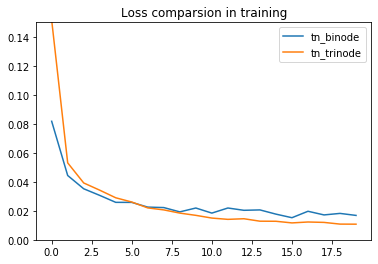

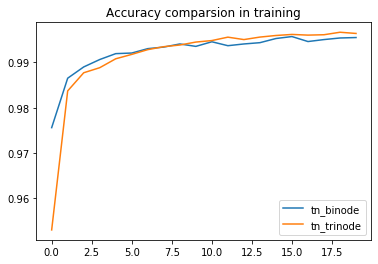

In [51]:
tn_loss = tn_hist.history['loss']
tn_acc = tn_hist.history['accuracy']

tn_loss2 = tn_hist2.history['loss']
tn_acc2 = tn_hist2.history['accuracy']

plt.plot(tn_loss, label='tn_binode')
plt.plot(tn_loss2, label='tn_trinode')
plt.title('Loss comparsion in training')
plt.ylim(0, 0.15)
plt.legend()
plt.show()

plt.plot(tn_acc, label='tn_binode')
plt.plot(tn_acc2, label='tn_trinode')
plt.title('Accuracy comparsion in training')
plt.legend()
plt.show()